In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df_train = pd.read_csv('data_capec.csv')
df_train.head()

,Unnamed: 0,text,label
0,0,GET /blog/index.php/2020/04/04/voluptatum-repr...,000 - Normal
1,1,GET /blog/xmlrpc.php?rsd,000 - Normal
2,2,GET /blog/index.php/2020/04/04/nihil-tenetur-e...,000 - Normal
3,3,GET /blog/index.php/2020/04/04/explicabo-qui-f...,000 - Normal
4,5,GET /blog/index.php/comments/feed/,000 - Normal


66 - SQL Injection                        182811
000 - Normal                               90915
194 - Fake the Source of Data              43324
34 - HTTP Response Splitting               18215
126 - Path Traversal                       11435
242 - Code Injection                        9825
272 - Protocol Manipulation                 2794
310 - Scanning for Vulnerable Software      2364
153 - Input Data Manipulation               1123
Name: label, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '66 - SQL Injection'),
  Text(1, 0, '000 - Normal'),
  Text(2, 0, '194 - Fake the Source of Data'),
  Text(3, 0, '34 - HTTP Response Splitting'),
  Text(4, 0, '126 - Path Traversal'),
  Text(5, 0, '242 - Code Injection'),
  Text(6, 0, '272 - Protocol Manipulation'),
  Text(7, 0, '310 - Scanning for Vulnerable Software'),
  Text(8, 0, '153 - Input Data Manipulation')])

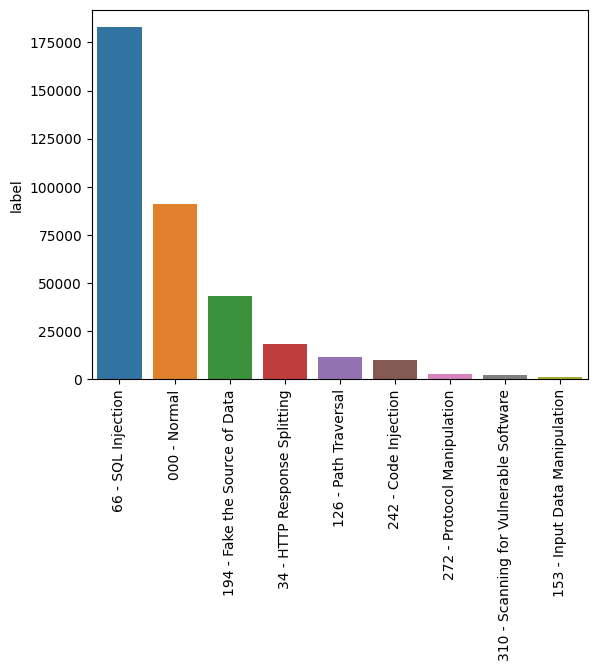

In [10]:
# CLASS DISTRIBUTION
#if dataset is balanced or not
x=df_train['label'].value_counts()
print(x)
sns.barplot(x = x.index, y = x)
plt.xticks(rotation=90)

# Create Feature Extraction Module (BOW and TF-IDF)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import json


class Vectorizer:
    def __init__(self, method='BOW', ngram_range=(1, 1), max_features=300, emb_fname='', word_index_fname=''):
        self.method = method
        if self.method == 'BOW':
            self.vectorizer = CountVectorizer(analyzer='word', input='content', ngram_range=ngram_range, max_features=max_features)
        elif self.method == 'TFIDF':
            self.vectorizer = TfidfVectorizer(analyzer='word', input='content', max_features=max_features)
        elif self.method == 'Word2Vec':
            self.max_features = max_features
            self.emb_fname = emb_fname
            self.word_index_fname = word_index_fname
        else:
            raise ValueError('Feature extraction method does not exist.')

    def feature_extraction(self, X_train, X_test):
        train_data = self.vectorizer.fit_transform(X_train).toarray()
        test_data = self.vectorizer.transform(X_test).toarray()
        return train_data, test_data

    def get_word_index(self):
        word2id = json.load(open(self.word_index_fname, 'r'))
        return word2id

    def get_embedding_matrix(self):
        np.random.seed(0)
        word2id = self.get_word_index()
        embedding_matrix = np.random.uniform(-0.25, 0.25, [len(word2id) + 1, self.max_features])
        with open(self.emb_fname, 'r', encoding='utf-8') as f:
            for line in f:
                content = line.split(' ')
                if content[0] in word2id:
                    embedding_matrix[word2id[content[0]]] = np.array(list(map(float, content[1:])))
        return embedding_matrix

In [5]:
# Optional (not effect very much)
df_train['text'] = df_train['text'].str.replace('/',' ')
df_train.head()

,Unnamed: 0,text,label
0,0,GET blog index.php 2020 04 04 voluptatum-repr...,000 - Normal
1,1,GET blog xmlrpc.php?rsd,000 - Normal
2,2,GET blog index.php 2020 04 04 nihil-tenetur-e...,000 - Normal
3,3,GET blog index.php 2020 04 04 explicabo-qui-f...,000 - Normal
4,5,GET blog index.php comments feed,000 - Normal


# TF-IDF Feature Extraction

## Naive Bayes Classifier

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
X_train, X_val, y_train, y_val = train_test_split(df_train["text"],
                                                  df_train["label"],
                                                  test_size=0.2,
                                                  shuffle=True)
vectorizer = Vectorizer('TFIDF')
train_features, test_features = vectorizer.feature_extraction(X_train, X_val)
mnb = MultinomialNB()
mnb.fit(train_features, y_train)
print(mnb.score(test_features, y_val))




0.8660455886000937


## Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, criterion='gini')
rf.fit(train_features, y_train)
print(rf.score(test_features, y_val))

0.9693641299853918


In [15]:
y_predict = rf.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.93      0.98      0.95     18260
                  126 - Path Traversal       1.00      0.93      0.96      2269
         153 - Input Data Manipulation       0.57      0.02      0.03       230
         194 - Fake the Source of Data       1.00      0.98      0.99      8624
                  242 - Code Injection       1.00      0.99      0.99      2002
           272 - Protocol Manipulation       0.51      0.09      0.15       563
310 - Scanning for Vulnerable Software       0.94      0.99      0.96       493
          34 - HTTP Response Splitting       1.00      1.00      1.00      3664
                    66 - SQL Injection       0.98      0.98      0.98     36457

                              accuracy                           0.97     72562
                             macro avg       0.88      0.77      0.78     72562
                          weighted avg

## Decision Tree Classifier

In [16]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini')
dt.fit(train_features, y_train)
print(dt.score(test_features, y_val))

0.9692263168049392


In [17]:
y_predict = dt.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.93      0.98      0.95     18260
                  126 - Path Traversal       0.99      0.93      0.96      2269
         153 - Input Data Manipulation       0.57      0.02      0.03       230
         194 - Fake the Source of Data       1.00      0.98      0.99      8624
                  242 - Code Injection       1.00      0.99      0.99      2002
           272 - Protocol Manipulation       0.45      0.10      0.17       563
310 - Scanning for Vulnerable Software       0.94      0.99      0.96       493
          34 - HTTP Response Splitting       1.00      1.00      1.00      3664
                    66 - SQL Injection       0.98      0.98      0.98     36457

                              accuracy                           0.97     72562
                             macro avg       0.87      0.78      0.78     72562
                          weighted avg

# AdaBoost Classifier

In [18]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators=10)
abc.fit(train_features, y_train)
print(abc.score(test_features, y_val))

0.6962321876464265


In [19]:
y_predict = abc.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                        precision    recall  f1-score   support

                          000 - Normal       0.00      0.00      0.00     18260
                  126 - Path Traversal       0.00      0.00      0.00      2269
         153 - Input Data Manipulation       0.00      0.00      0.00       230
         194 - Fake the Source of Data       1.00      0.98      0.99      8624
                  242 - Code Injection       1.00      0.96      0.98      2002
           272 - Protocol Manipulation       0.00      0.00      0.00       563
310 - Scanning for Vulnerable Software       0.00      0.00      0.00       493
          34 - HTTP Response Splitting       1.00      1.00      1.00      3664
                    66 - SQL Injection       0.62      1.00      0.77     36457

                              accuracy                           0.70     72562
                             macro avg       0.40      0.44      0.42     72562
                          weighted avg

c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic Regression Classifier

In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_features, y_train)
print(lr.score(test_features, y_val))


0.9603098040296574


c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
y_predict = lr.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.90      0.97      0.94     18260
                  126 - Path Traversal       0.98      0.92      0.94      2269
         153 - Input Data Manipulation       0.33      0.00      0.01       230
         194 - Fake the Source of Data       1.00      0.98      0.99      8624
                  242 - Code Injection       1.00      0.97      0.98      2002
           272 - Protocol Manipulation       0.00      0.00      0.00       563
310 - Scanning for Vulnerable Software       0.93      0.95      0.94       493
          34 - HTTP Response Splitting       1.00      1.00      1.00      3664
                    66 - SQL Injection       0.98      0.97      0.97     36457

                              accuracy                           0.96     72562
                             macro avg       0.79      0.75      0.75     72562
                          weighted avg

# BOW Feature Extraction

## Naive Bayes Classifier

In [22]:
vectorizer = Vectorizer('BOW')
train_features, test_features = vectorizer.feature_extraction(X_train, X_val)
mnb = MultinomialNB()
mnb.fit(train_features, y_train)
print(mnb.score(test_features, y_val))

0.8202778313717924


In [23]:
y_predict = mnb.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.69      0.88      0.77     18260
                  126 - Path Traversal       0.99      0.90      0.94      2269
         153 - Input Data Manipulation       0.08      1.00      0.16       230
         194 - Fake the Source of Data       0.98      0.95      0.96      8624
                  242 - Code Injection       0.96      0.84      0.90      2002
           272 - Protocol Manipulation       0.04      0.13      0.07       563
310 - Scanning for Vulnerable Software       0.90      0.50      0.64       493
          34 - HTTP Response Splitting       0.94      0.97      0.95      3664
                    66 - SQL Injection       0.96      0.75      0.84     36457

                              accuracy                           0.82     72562
                             macro avg       0.73      0.77      0.69     72562
                          weighted avg

## Random Forest Classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, criterion='gini')
rf.fit(train_features, y_train)
print(rf.score(test_features, y_val))

0.9691711915327582


In [25]:
y_predict = rf.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.93      0.98      0.95     18260
                  126 - Path Traversal       1.00      0.93      0.96      2269
         153 - Input Data Manipulation       0.57      0.02      0.03       230
         194 - Fake the Source of Data       1.00      0.98      0.99      8624
                  242 - Code Injection       1.00      0.99      0.99      2002
           272 - Protocol Manipulation       0.46      0.11      0.18       563
310 - Scanning for Vulnerable Software       0.94      0.99      0.97       493
          34 - HTTP Response Splitting       1.00      1.00      1.00      3664
                    66 - SQL Injection       0.98      0.98      0.98     36457

                              accuracy                           0.97     72562
                             macro avg       0.87      0.78      0.78     72562
                          weighted avg

## Decision Tree Classifier

In [26]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini')
dt.fit(train_features, y_train)
print(dt.score(test_features, y_val))

0.9699980706154737


In [27]:
y_predict = dt.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.93      0.98      0.95     18260
                  126 - Path Traversal       0.99      0.93      0.96      2269
         153 - Input Data Manipulation       0.50      0.02      0.03       230
         194 - Fake the Source of Data       1.00      0.98      0.99      8624
                  242 - Code Injection       1.00      1.00      1.00      2002
           272 - Protocol Manipulation       0.52      0.12      0.20       563
310 - Scanning for Vulnerable Software       0.94      1.00      0.97       493
          34 - HTTP Response Splitting       1.00      1.00      1.00      3664
                    66 - SQL Injection       0.98      0.98      0.98     36457

                              accuracy                           0.97     72562
                             macro avg       0.87      0.78      0.79     72562
                          weighted avg

## AdaBoost Classifier

In [28]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators=10)
abc.fit(train_features, y_train)
print(abc.score(test_features, y_val))

0.6962321876464265


In [29]:
y_predict = abc.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                        precision    recall  f1-score   support

                          000 - Normal       0.00      0.00      0.00     18260
                  126 - Path Traversal       0.00      0.00      0.00      2269
         153 - Input Data Manipulation       0.00      0.00      0.00       230
         194 - Fake the Source of Data       1.00      0.98      0.99      8624
                  242 - Code Injection       1.00      0.96      0.98      2002
           272 - Protocol Manipulation       0.00      0.00      0.00       563
310 - Scanning for Vulnerable Software       0.00      0.00      0.00       493
          34 - HTTP Response Splitting       1.00      1.00      1.00      3664
                    66 - SQL Injection       0.62      1.00      0.77     36457

                              accuracy                           0.70     72562
                             macro avg       0.40      0.44      0.42     72562
                          weighted avg

c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic Regression Classifier

In [30]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_features, y_train)
print(lr.score(test_features, y_val))

0.962321876464265


c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
y_predict = lr.predict(test_features)
print(classification_report(y_val,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.91      0.97      0.94     18260
                  126 - Path Traversal       1.00      0.93      0.96      2269
         153 - Input Data Manipulation       0.26      0.06      0.10       230
         194 - Fake the Source of Data       1.00      0.98      0.99      8624
                  242 - Code Injection       1.00      0.98      0.99      2002
           272 - Protocol Manipulation       0.67      0.01      0.01       563
310 - Scanning for Vulnerable Software       0.92      0.99      0.95       493
          34 - HTTP Response Splitting       1.00      1.00      1.00      3664
                    66 - SQL Injection       0.98      0.97      0.97     36457

                              accuracy                           0.96     72562
                             macro avg       0.86      0.77      0.77     72562
                          weighted avg

# Word2Vec Feature Extraction

In [32]:
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_train["text"],
                                                  df_train["label"],
                                                  test_size=0.2,
                                                  shuffle=True)

In [34]:
from gensim.models import Word2Vec

sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, window=5, min_count=5, workers=4)

In [35]:
import numpy as np

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

In [36]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.5744328987624376


c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
y_predict = clf.predict(X_test)
print(classification_report(y_test,y_predict))
print('Confusion Matrix: \n',confusion_matrix(y_test, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.43      0.45      0.44     18252
                  126 - Path Traversal       0.46      0.08      0.14      2229
         153 - Input Data Manipulation       0.00      0.00      0.00       231
         194 - Fake the Source of Data       0.23      0.02      0.04      8706
                  242 - Code Injection       0.22      0.01      0.01      1967
           272 - Protocol Manipulation       0.00      0.00      0.00       562
310 - Scanning for Vulnerable Software       0.69      0.93      0.79       451
          34 - HTTP Response Splitting       0.37      0.10      0.16      3598
                    66 - SQL Injection       0.64      0.88      0.74     36566

                              accuracy                           0.57     72562
                             macro avg       0.34      0.28      0.26     72562
                          weighted avg

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df_train["text"],
                                                  df_train["label"],
                                                  test_size=0.2,
                                                  shuffle=True)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df_train["text"],
                                                  df_train["label"],
                                                  test_size=0.2,
                                                  shuffle=True)
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

# Pad the sequences to a fixed length
max_length = 100
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

In [40]:
## importing all libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

## Case 1 : Would use Word2Vec and then apply different classifiers
from gensim.models import Word2Vec  

## Case 2 : Would use TfidfVectorizer and then apply different classifiers
from sklearn.feature_extraction.text import TfidfVectorizer   

## This would help us understand : Does the type of Vectorizing Process influence the precision , accuracy , recall score of the classifiers ??


from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [41]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
# Classification using word2vec vectorizer
# Tokenize : dividing Sentences into words
df_train['text_clean'] = df_train['text'].apply(nltk.word_tokenize)
print('Tokenization complete.')

vec_model = Word2Vec(df_train['text_clean'])

w2v = dict(zip(vec_model.wv.index_to_key, vec_model.wv.vectors))
## What is syn0 ?
## https://stackoverflow.com/questions/53301916/python-gensim-what-is-the-meaning-of-syn0-and-syn0norm

class Vectorizer(object):
    
    def __init__(self, vec):
        self.vec = vec
        self.dim = len(vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean([self.vec[w] for w in words if w in self.vec] or [np.zeros(self.dim)], axis=0) for words in X])


## for any Classifier , we need intialise the model with the parameters. 
## Further I am applying GridSearchCV for 5 runs (i.e 1/5th data used each time for testing) 
## So the model gets trained over 5 runs 
## as well we are predicting also over 5 runs
## In case if you wish to know about Cross Validation , you can watch my Video here : https://www.youtube.com/watch?v=LmxsySwAhoE&t=84s
class Classifier(object):
    
    def __init__(self, model, param):
        self.model = model
        self.param = param
        self.gs = GridSearchCV(self.model, self.param, cv=5, error_score=0, refit=True)        

    def fit(self, X, y):        
        return self.gs.fit(X, y)

    def predict(self, X):
        return self.gs.predict(X)
    

## Preparing to make a pipeline 
clf_models = {
    'Naive Bayes': GaussianNB(), 
    'Decision Tree': DecisionTreeClassifier(),  
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier()
}

clf_params = {
    'Naive Bayes': { }, 
    'Decision Tree': { 'min_samples_split': [2, 5] }, 
    'Random Forest': { },
    'AdaBoost': {  }
}


## splitting the dataset into 80:20.  have kept shuffle=True , so that the data is randomly sampled or simply said shuffled , and then split.
X_train, X_test, y_train, y_test = train_test_split(df_train['text'], df_train['label'], test_size=0.2, shuffle=True)

## for loop traverses , each and every classifier and its corresponding parameters.
for key in clf_models.keys():
    
    clf = Pipeline([('Word2Vec vectorizer', Vectorizer(w2v)), ('Classifier', Classifier(clf_models[key], clf_params[key]))])
    
    clf.fit(X_train, y_train)  ## Note : we are calling user defined fit method. This fit method uses Cross Validation
    y_pred = clf.predict(X_test)  ## Note : we are calling user defined predict method. This predict method uses Cross Validation
    
    ## printing performance metrics for each classifier 
    print(key, ':')
    print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')))
    print('Confusion Matrix: \n',confusion_matrix(y_test, y_pred))

Tokenization complete.
Naive Bayes :
Accuracy: 0.568 	Precision: 0.370 	Recall: 0.630 		F1: 0.397

Confusion Matrix: 
 [[ 4659   399   446  2906   896  3106  1796  2302  1815]
 [   22  1188    22    39   857    54   113     4     1]
 [    0     0   206    17     0    21     0     0     0]
 [  547    81   490  5528   360   463   197   895    11]
 [  102    43    13   153  1550     4     0    26    11]
 [   81     4    57    28     1   122   278     6     5]
 [    5     1     0     0     1    22   402     0     0]
 [  267     2   166   226     1   133     4  2805    27]
 [ 3484  1134   629  1546   846  1876   669  1666 24725]]
Decision Tree :
Accuracy: 0.923 	Precision: 0.753 	Recall: 0.746 		F1: 0.749

Confusion Matrix: 
 [[16207    85    50   341    65   295    58   111  1113]
 [   87  2140     6    14     1    18    11     0    23]
 [   53     3    62    38     0    16     0     0    72]
 [  367    12    40  7809    38    40    10    20   236]
 [   76     4     1    59  1720     1    